# Project 4 – Numerical Integration
## MATH 3316 High Performance Scientific Computing, Fall 2016

Author: Paul Herz

The designated programming language for this project was C++, built in Xcode and compiled with Clang (Apple LLVM 8.0.0) using the C++14 dialect.

### Structure of this Project

This project's file structure follows the GNU-style C++ project standard.

In [1]:
%ls ..

HPSCProject4.xcodeproj/ lib/                    src/
bin/                    notebooks/
data/                   reports/


Excluding the `.xcodeproj` file, which was used for integration with the Xcode IDE, debugging, and profiling purposes, each item in the project directory serves the following purpose:

- `Makefile`: GNU Make project build automation definitions
- `bin/`: compiled binaries. Make will put binaries here by default.
- `data/`: where calculated data is stored after program execution. Files are `.txt` files containing real numbers, space delimited to denote row items, and newline delimited to denote new rows.
- `lib/`: reused libraries that are not part of this project specifically. Contains my rewrite of the Matrix library ([phrz/matrix](https://github.com/phrz/matrix)).
- `notebooks/`: Python 3 Jupyter notebooks, notably the one used to generate this report.
- `reports/`: PDFs generated from the Jupyter notebooks via `nbconvert` and `pdflatex`.
- `src/`: contains the main mathematical routines described in this report, which are used to generate the data and redirected output in `data/`.

### Using this Project

#### Prerequisites
- A Unix or Unix-like OS (e.g. macOS or Linux)
- A compiler with support for C++14 (LLVM or GNU toolchain)
- Python ≥3.5
- The latest Jupyter distribution
- LaTeX with `pdflatex`
- GNU Make ≥3.81

#### Building this project
This project provides several GNU Make targets, with a handful of them being especially useful.

`make all` (default) - will compile binaries, execute them to generate data files, execute Jupyter notebooks under fresh kernels with just-generated data files, and convert them to PDFs in `/reports`.

`make all_bin` - will compile binaries for parts A, B, and C (`test_int`, `test_adapt`, and `test_carbon`) of this project.

`make all_data` - will compile binaries and execute them to generate data files.

`make clean` - will delete all compiled binaries, generated data, executed notebook copies (but not the original notebooks), and **report PDFs**.

Below, find attached the full Makefile:

In [2]:
%cat ../Makefile

#
#  Makefile
#  HPSCProject4
#
#  Created by Paul Herz on 12/1/16.
#  Copyright © 2016 Paul Herz. All rights reserved.
#

TARGETA = test_int
TARGETB = test_adapt
TARGETC = test_carbon

CXX = g++
CFLAGS = -std=c++14

SRC = src/
LIB = lib/
BIN = bin/
ROOT = $(shell pwd)/
DATA = data/
NB = notebooks/
RP = reports/

AFILES = test_int.cpp
BFILES = test_adapt.cpp
CFILES = test_carbon.cpp
CLIBFILES = Vector.cpp Matrix.cpp

NOTEBOOKABC = $(NB)proj4.ipynb
NOTEBOOKC = $(NB)carbon.ipynb
REPORTABC = $(RP)proj4.pdf
REPORTC = $(RP)carbon.pdf



################################
# All target                   #
################################

all: all_bin all_data all_reports



################################
# Application binaries         #
################################

all_bin: $(TARGETA) $(TARGETB) $(TARGETC)

$(TARGETA):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETA) $(addprefix $(SRC), $(AFILES))

$(TARGETB):
	$(CXX) $(CFLAGS) -o $(BIN)$(TARGETB) $(addprefix $(SRC), $(BFILES))

$(TARGETC):
	$(CXX

## Part A – Composite Numerical Integration

### Goals

This part is concerned with the development of a composite integration algorithm of sufficiently fast convergence. We were provided base example code that implemented 2-node Gaussian composite integration.

### Math Background

#### Gaussian Quadrature

In the Gaussian Quadrature algorithm for composite integration, one evaluates $n$ subintervals of the interval of integration $[a,b]$ by dividing it into intervals of width $h=(b-a)/n$. For each subinterval $s_i$, where $i \in \mathbb{Z}, [0,n-1]$, the algorithm considers the midpoint $m=a+(i+0.5)*h$. From this midpoint, a set of nodes are determined as offset from the midpoint. Corresponding to these nodes are weights $w_j$. In the case of the two-node example code, the offsets are $x_0=-\sqrt{1/3},\ x_1 = \sqrt{1/3}$ and the weights are both $1$.
The $j^{\mathrm{th}}$ node is calculated as $N_j=m+0.5*h*x_j$. Note well that the offsets are scaled based on subinterval size rather than added directly! 

Now, using our set of evaluation points $N_0,N_1$ (in the two-node case),  integrand $f(x)$ and known weights $w_0,w_1$, we evaluate the $i^{\mathrm{th}}$ subinterval:

$$
S(i) = \sum_{j} w_j * f(N_j(i))
$$

Where in the two node case,

$$
N_0(i) = m(i) + 0.5*h*-\sqrt{1/3}
$$

$$
N_1(i) = m(i) + 0.5*h*\sqrt{1/3}
$$

and where $m(i)$ yields the $i^{\mathrm{th}}$ midpoint,
$$
m(i) = a + (i+0.5)*h
$$

Assuming $[a,b]$ and $h$ are variables of the algorithm. Then to calculate the full interval we sum the subintervals:

$$
I = \frac{h}{2} \sum_{i} S(i)
$$

### Implementation Requirements

#### Composite Numerical Integration

I had to implement a composite numerical integration algorithm that could converge on an actual integral value on the order of $h^8$ (not to be confused with [Big-O notation](https://en.wikipedia.org/wiki/Big_O_notation), an upper bound function). The example code given was 2-node Gaussian quadrature which converged on the order of $h^8$, so I attempted to re-implement it as 4-node ($n=3$) Gaussian quadrature, primarily by expanding the array of nodes and weights using formulae found in a table on Wikipedia ([Wikipedia: Gaussian Quadrature](https://en.wikipedia.org/wiki/Gaussian_quadrature)).

Initially, this algorithm appeared to work well and converge correctly, but this was due to a grave misunderstanding of the instructions, which used Big-O notation to mean "on the order of," which runs contrary to the use of this notation in Computer Science (although I have found it is used differently in some maths). My algorithm originally converged on the order of $h^2$, but because Big-O notation was used, I assumed that $\mathcal{O}(h^2)\in\mathcal{O}(h^8)$ (which would be correct under the nomenclature of computer science but not of some maths), and that I could move on. 

I was correctly very shortly before the due date, and sought to improve the convergence of my algorithm, which qualified individuals believed should have been on the order of $h^8$. I tried many adjustments to my algorithm, but finally found that by precalculating my weights and nodes and inserting them into my code as decimal literals, I was losing a lot of precision compared to just expressing them as mathematical statements and allowing C++ to handle high-precision calculation. This resolved the wide discrepancy of order of convergence between my $h^2$ and the typical $h^8$ of four node Composite Gaussian Quadrature.

#### Integration Testing

My test file follows the example of `test_Gauss2` and uses the function:
$$
f(x) = e^{cx} + \sin(dx)
$$
whose exact antiderivative is:
$$
F(x) = \frac{e^{cx}}{c} - \frac{\cos{dx}}{d}
$$

I first evaluate the true integral:
$$
I = \int_{a}^{b} f(x)dx = F(b) - F(a)
$$

And then, at each $n\in\lbrace 20, 40, 80, 160, 320, 640, 1280, 2560, 5120, 10240 \rbrace$, I use my `composite_int(f,a,b,n)` function to approximate function `f` over `[a,b]` using `n` subintervals. I record
a table with a row listing `n`, `R` (the approximation), `e` (the relative error) and convergence.

Relative error is calculated using true integral $I$ and approximation $R$:
$$
\epsilon = \frac{|I-R|}{|I|}
$$

And the $i^{\mathrm{th}}$ convergence exponent is calculated:
$$
C_i = \frac{ \log(\epsilon_{i-1}) - \log(\epsilon_i) }{ \log(h_{i-1}) - \log(h_i) }
$$

Where $\epsilon_i$ is the error for the current iteration of $n$ and $\epsilon_{i-1}$ is that of the prior iteration, and the same subscripts of $h$ represent the current and prior iterations as well. As such, the convergence exponent is incalculable for reasons of indexing and common sense (a single datapoint has no delta!)

### Implementation

#### Composite Numerical Integration

In [3]:
%cat ../src/composite_int.cpp

//
//  composite_int.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/15/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#ifndef _s
#define _s std::to_string
#endif

#include <iostream>
#include <exception>
#include <cmath>

using Fcn = std::function<double(double)>;

// Integrate function `f` on the interval `a` to `b`
// with `n` subintevals of width |b-a|/n.

// NOTE: using template instead of Fcn directly to avoid the overhead of
// std::function, see:
// http://blog.demofox.org/2015/02/25/avoiding-the-performance-hazzards-of-stdfunction/

template<typename T>
double composite_int(T& f, const double a, const double b, const int n) {
	// implement a composite numerical integration formula that is
	// O(h^8) accurate.
	
	// PRECONDITIONS:
	// (1) [a,b] is a valid, forward interval.
	if(b < a) {
		throw std::invalid_argument("The interval [a,b] is invalid, b < a.");
	}
	
	// (2) `n` is a nonzero quantity (integer)
	if(n < 1) {
		throw std::invalid_argument("The numb

#### Integration Testing

In [5]:
%cat ../src/test_int.cpp

//
//  test_int.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/15/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <iostream>
#include <cmath>
#include <vector>
#include <experimental/optional>
#include <string>
#include <sstream>

#include "println.cpp"
#include "composite_int.cpp"

template<class T>
using optional = std::experimental::optional<T>;

using namespace std;

string leftPad(string s, size_t size, char pad = ' ') {
	size_t difference = size - s.size();
	return string(difference, pad) + s;
}

string rightPad(string s, size_t size, char pad = ' ') {
	size_t originalSize = s.size();
	if(originalSize == size) {
		return s;
	}
	
	// either truncate or pad the string depending
	// on requested size vs actual size.
	s.resize(size, pad);
	
	// if shrunken, replace last character with
	// ellipsis character.
	if(originalSize > size) {
		s.replace(originalSize-1, 1, "…");
	}
		
	return s;
}

template<typename T>
string leftPad(T t, size_t size, char pad =

#### Output

In [7]:
%cat ../data/test_int_out.txt

True integral: 23.9241
┌────────┬────────────┬─────────────┬───────────────┐
|      n |   approx   |    error    |  convergence  |
├────────┼────────────┼─────────────┼───────────────┤
│     20 │ 23.9249    │ 3.48056e-05 │ n/a           │
│     40 │ 23.9241    │ 1.76071e-07 │ 7.627017      │
│     80 │ 23.9241    │ 2.43717e-10 │ 9.496734      │
│    160 │ 23.9241    │ 7.94769e-13 │ 8.260457      │
│    320 │ 23.9241    │ 2.37599e-15 │ 8.385862      │
│    640 │ 23.9241    │ 1.48499e-15 │ 0.678072      │
│   1280 │ 23.9241    │ 7.42497e-16 │ 1.000000      │
│   2560 │ 23.9241    │ 1.63349e-15 │ -1.137504     │
│   5120 │ 23.9241    │ 5.93998e-16 │ 1.459432      │
│  10240 │ 23.9241    │ 5.93998e-16 │ 0.000000      │
└────────┴────────────┴─────────────┴───────────────┘


Note that I satisfy the convergence requirement (of being on the order of $h^8$) as per the parameters of the section of the project. Once the algorithm has converged sufficiently on the value at lower $n$ values, the convergence order fluctuates, as convergence slows down as the approximate value is perhaps already so precise - just a hypothesis.

## Part B – Adaptive Numerical Integration

### Goals

This part is concerned with building upon the composite integration algorithm in the first part. Whereas the first part would approximate `n` subintervals where `n` was given before returning successfully, this part will target a certain degree of accuracy as the condition of success.

### Implementation Requirements

#### Adaptive Numerical Integration

I needed to implement `adaptive_int(f,a,b,rtol,atol,&R,&n,&Ntot)`, where `f` is the integrand closure, `[a,b]` is the real interval of integration, `rtol` and `atol` are error maxima (tolerance requirements) which are preconditions for success, `R` is a passthrough variable in which the approximate integral is stored, `n` is a passthrough for the final number of subintervals which satisfied the tolerances, and `Ntot` is the sum of all subintervals evaluated up to and until success.

The gist of the adaptive algorithm is this: starting at the given `n` value, evaluate the composite integration function `composite_int(f,a,b,n)`, then determine if the definitions of `rtol` and `atol` are satisfied. Increment `Ntot` by `n`, and if the tolerance stipulations are satisfied, set `R` to the result of the `composite_int` step and return. Otherwise, increment `n` using an arbitrary and heuristic function, and repeat from the `composite_int` step with the new `n`. Thus the algorithm will evaluate an increasing number of subintervals until it meets tolerance, but in fact it throws out all subinterval calculations except for those in the final successful step. As such, there is a lot of potential for *computational waste* and inefficiency in this algorithm.

However, the evaluation and "waste" of early subintervals is a necessary evil for knowing when to continue calculation at higher subinterval count `n` (for greater precision) versus when sufficient precision is met. Nonetheless, there is a lot of room for efficiency as well as a lack thereof in this process due to the nature of the algorithm, and the critical point at which we optimize this algorithm is the aforementioned **heuristic incrementor** (vidit supra).

The simplest heuristic incrementor is objectively and quantitatively terrible, but is not the worst starting point: $n_{i+1} = n_i + 1$, more recognizable to a programmer as `n++`. Yes, we could linearly increment `n` by one, but in Big-O notation (time complexity, *not mathematical order!*) this algorithm is $\mathcal{O}((n+i)!-n!)$ where $i$ is the requisite iteration count to meet tolerance requirements.

I began with a rather poor heuristic, $n_{i+1} = (n_i + 1)^5$, which increases much quicker than the previous heuristic, but is not much better: it increases so fast that it "overshoots" the sweet spot of tolerance: just the minimum number of subintervals to minimize computation, without too many intermediate "waste" subinterval evaluations. The iteration that satisfies tolerance in this heuristic will always oversatisfy it, doing far more calculations throughout and on the final step than required, so by the two above metrics of a good heuristic, this is very poor.

After discussion on proper heuristics, I chose to use a simpler and more gradual heuristic, $x_{i+1} = 1.5*x_i+10$. This heuristic massively reduced my total number of calculations (computational weight) by several orders of magnitude. 

#### Adaptive Testing

My adaptive testing code was based on the requirements outlined in the project document, and tested the computational efficiency of my algorithm. The results of this calculation is included below the code implementation that follows. The code for `adaptive_int` is very thoroughly commented to describe the nature of the algorithm and the test code is similarly, yet more minimally, documented for your edification.

### Implementation

#### Adaptive Numerical Integration

In [8]:
%cat ../src/adaptive_int.cpp

//
//  adaptive_int.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/16/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <cmath>
#include "println.cpp"
#include "composite_int.cpp"

using Fcn = std::function<double(double)>;

// Call `composite_int` adaptively, such that
//
//     abs( I(f) - Rn(f) ) < rtol * abs( I(f) ) + atol
//
// Where I(f) is the integral, and Rn(f) is the `composite_int` function,
// and computation is minimized to achieve the above condition.
//
// Because the true integral is not known, we can use the rapid convergence
// of `composite_int` to approximate I(f) in a way that helps find `n`.
// Beginning with k at an arbitrary value, update `n` until this
// approximation is satisfied:
//
//     abs( Rn+k(f) - Rn(f) ) < rtol * abs( Rn+k(f) ) + atol

template<typename T>
int adaptive_int(T& f, const double a, const double b, const double rtol,
				 const double atol, double& R, int& n, int& Ntot)
{
	// Compute the integral of f(x) over [

#### Adaptive Testing

In [9]:
%cat ../src/test_adapt.cpp

//
//  test_adapt.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/16/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <vector>
#include <cmath>
#include "adaptive_int.cpp"
#include "println.cpp"

using namespace std;

int main() {
	
	// Evaluate the same problem as `test_int`:
	
	// limits of integration
	double a = -3.0;
	double b = 5.0;
	
	double c = 0.5;
	double d = 25.0;
	
	// function
	Fcn f = [&](double x) {
		return (exp(c*x) + sin(d*x));
	};
	
	// antiderivative
	Fcn F = [&](double x) {
		return (exp(c*x)/c - cos(d*x)/d);
	};
	
	// Let:
	//
	//     rtol = {10^-2, 10^-4, 10^-6 ..., 10^-12}
	//     atol_i = rtol_i/1000
	//
	// For each set of tolerances, print |I(f)-R(f)| and rtol*|I(f)|+atol,
	// as well as `n` and `Ntot`.
	
	size_t t_s = 6;
	vector<double> rtol(t_s);
	vector<double> atol(t_s);
	
	// Iterate once to build rtol and atol.
	for(int i = 0; i < t_s; ++i) {
		rtol[i] = std::pow(10.0, -2*(i+1));
		atol[i] = rtol[i]/1000;
	}
	
	size_t computa

#### Output

In [10]:
%cat ../data/test_adapt_out.txt

rtol:  0.01 	atol: 1e-05
n: 6 	Ntot: 25 	R: 23.868755 


rtol:  0.0001 	atol: 1e-07
n: 19 	Ntot: 82 	R: 23.925474 


rtol:  1e-06 	atol: 1e-09
n: 38 	Ntot: 187 	R: 23.924081 


rtol:  1e-08 	atol: 1e-11
n: 67 	Ntot: 364 	R: 23.924089 


rtol:  1e-10 	atol: 1e-13
n: 110 	Ntot: 649 	R: 23.924089 


rtol:  1e-12 	atol: 1e-15
n: 175 	Ntot: 1096 	R: 23.924089 


Total computational cost of these tests: 2403


Note that the integrand and interval for this test is identical to Part A, so the true integral is identical. My heuristic has managed to make the total computational load of this test very low compared to earlier heuristics I attempted.

## Part C – Application in Steel Carburizing

### Goals

This part is concerned with a real-world scenario in which computerized numerical integration is very useful in computing values for industrial use and visualization.

### Math Background

#### Carburizing

Carburizing is the process by which raw steel is strengthed by imbuing its internal structure with a higher concentration of carbon. This process involves putting raw steel in a carburizing furnace or "kiln" which is operating at very high temperatures and which has been evacuated of air, replaced by a high-carbon gas, the gaseous carburizing medium. Over time, at a non-constant rate, the concentration of carbon within the steel increases. For obvious reasons, carbon concentration does not increase uniformly throughout the steel, but increases most readily at or near the surface of the steel, and more gradually (or not at all) at greater depths within the sample.

For the purposes of this computational scenario, we were to assume that the carburizing process was undertaken at a fixed temperature, i.e. the furnace is preheated to an exact temperature that does not change at all throughout a theoretically indefinite process. All samples of steel in this exercise are identical, having the same initial concentration of carbon ($C_0$) uniformly distributed from the surface to the center, and all carburizing media are indentical in their gas concentration of carbon ($C_S$) as well.

We were to implement a known function $C$ which calculates the concentration of carbon within a steel sample undergoing carburization (constant $C_0$ and $C_S$ concentrations) measured at a point that is $x$ meters from the surface of the steel, after $t$ seconds in the furnace, which has been run from $t=0$ at a fixed temperature $T$ in Kelvin.

This function is given by:
$$
C(x,t,T) = C_S - (C_S-C_0) 
\cdot
\operatorname{erf}
\left(
\frac{x}{
    \sqrt{4tD(T)}
}
\right)
$$

"erf" is the Gauss error function, a common and specific mathematical
function that is described below. $D(T)$ is the steel diffusion coefficient, which is dependent upon environmental temperature $T$. The coefficient is given by:
$$
D(T) = 6.2e-7 \cdot \operatorname{exp}\left(  \right)
$$

#### The Gauss Error Function, `erf`

The error function, represented in mathematics and computers as $\operatorname{erf}(x)$, is a common and well-established mathematics function with many uses. The function generates a sigmoid curve with applications in diffusion (in this case, the diffusion of carbon into steel). It is calculated as:
$$
\operatorname{erf}(x) = \frac{2}{\sqrt\pi}\int_0^x e^{-t^2}
$$
It is actually an integral over $[-x,x]$ but due to its half-turn symmetry about zero, $I[-x,x](y)=2\cdot I[0,x](y)$.

### Implementation Requirements

At a minimum, two functions were required, but I additionally implemented a separate `diffusion` function for the sake of organization and separation of concerns.

#### Carburizing Function

The carburizing function `carbon(x,t,T,rtol,atol)` implements the above function $C(x,t,T)$ outlined in the "Carburizing" section of "Math Background" via the `erf` implementation below. Per se it is very simple, capable of fitting into one line of code if not for the very detailled documentation and readability efforts made for academic purposes. It calculates the parameter of `erf` as per the $C()$ function, then uses the `diffusion` function, the `erf` function, and the known constants $C_0$ and $C_S$ (see Carburizing in Math Background) to calculate concentration at depth at time given temperature.

#### Error Function

The error function, as described above, involves an integral, which we use `adaptive_int` to approximate. `erf(y,rtol,atol)` approximates $\operatorname{erf}(y)$ using `adaptive_int`, while passing through the given error maxima (tolerances `rtol` and `atol`). The `erf` integrand is
given as a static closure so that it does not produce overhead on the `erf` function through instantiation after the first run – this is the optimizing benefit of static variables in functions.

#### Carbon Calculations

All carburizing calculations were made as per the requirements in the packets and exported to file.

### Implementation

#### Composite Numerical Integration

In [11]:
%cat ../src/carbon.cpp

//
//  carbon.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/30/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <cmath>
#include "println.cpp"
#include "adaptive_int.cpp"

// The temperature (Kelvin) dependent diffusion coefficient of steel
double diffusion(double T) {
	return 6.2e-7 * exp(-8.0e4/(8.31*T));
}

// Use adaptive_int() to approximate the error function `erf` within given
// tolerances
double erf(const double y, const double rtol, const double atol) {
	// Use adaptive_int to evaluate the error function
	//
	// erf(y) = 2/sqrt(pi) I[0,y]( exp(-t^2) dt )
	//
	
	// the coefficient 2/sqrt(pi)
	static const double erfCoefficient = 1.1283791671;
	static Fcn erfIntegrand = [](double t){ return exp(-pow(t,2)); };
	
	int n, Ntot;
	double integral;
	int error = adaptive_int(erfIntegrand, 0.0, y, rtol, atol, integral, n, Ntot);
	
	if(error != 0) {
		println("[erf] integral approximation failed during evaluation of the error function.");
		return 0;
	}
	
	

#### Carbon Calculations

In [13]:
%cat ../src/test_carbon.cpp

//
//  test_carbon.cpp
//  HPSCProject4
//
//  Created by Paul Herz on 11/30/16.
//  Copyright © 2016 Paul Herz. All rights reserved.
//

#include <string>
#include "carbon.cpp"
#include "println.cpp"
#include "Vector.h"
#include "Matrix.h"

#ifndef _s
#define _s std::to_string
#endif

using namespace PH;

int main() {
	
	std::string prefix = "../data/";
	
	// All computations should use rtol = 10^−11 and atol = 10^−15.
	const double rtol = 1e-11;
	const double atol = 1e-15;
	
	
	// 1. Generate a linear span of 400 T (temperature in K)
	//    values over [800,1200].
	auto temperatureVals = Vector::linSpace(800, 1200, 400);
	temperatureVals.saveTo(prefix+"Temp.txt");
	
	
	// 2. Generate a linear span of 600 t (time in seconds) values from
	//    one second to two days.
	int twoDays = 2*24*60*60;
	auto timeVals = Vector::linSpace(1, twoDays, 600);
	timeVals.saveTo(prefix+"time.txt");
	
	
	// 3. For each depth m, 4mm], do the following:
	for(int depth : {2, 4}) {
		
		// `x` must be in me

### Graphs and Analyses

The below graphs and analyses are entirely reproduced from `carbon.ipynb`, which is a separate notebook available in report form in `carbon.pdf` in the same directory as this file. They are reproduced here solely for purposes of convenience and completeness.

In [14]:
%pylab inline
pylab.rcParams['figure.figsize'] = (10, 6)
matplotlib.rcParams.update({'font.size': 16})
matplotlib.rcParams.update({'axes.labelsize': 20})
matplotlib.rcParams.update({'xtick.labelsize': 12})
matplotlib.rcParams.update({'ytick.labelsize': 12})
matplotlib.rcParams.update({
        'font.family': 'Helvetica, Arial, sans-serif'
})

%config InlineBackend.figure_format = 'retina'

path = '../data/'
names = ['C2mm','C4mm','C2mm_800K','C2mm_900K','C2mm_1000K','C2mm_1100K','C2mm_1200K', 
         'C4mm_800K','C4mm_900K','C4mm_1000K','C4mm_1100K','C4mm_1200K', 'time']
v = {}

v['a'] = pylab.linspace(-4,4,201)
v['b'] = pylab.linspace(-4,4,101)

for name in names:
    v[name] = loadtxt(path+name+'.txt')

Populating the interactive namespace from numpy and matplotlib


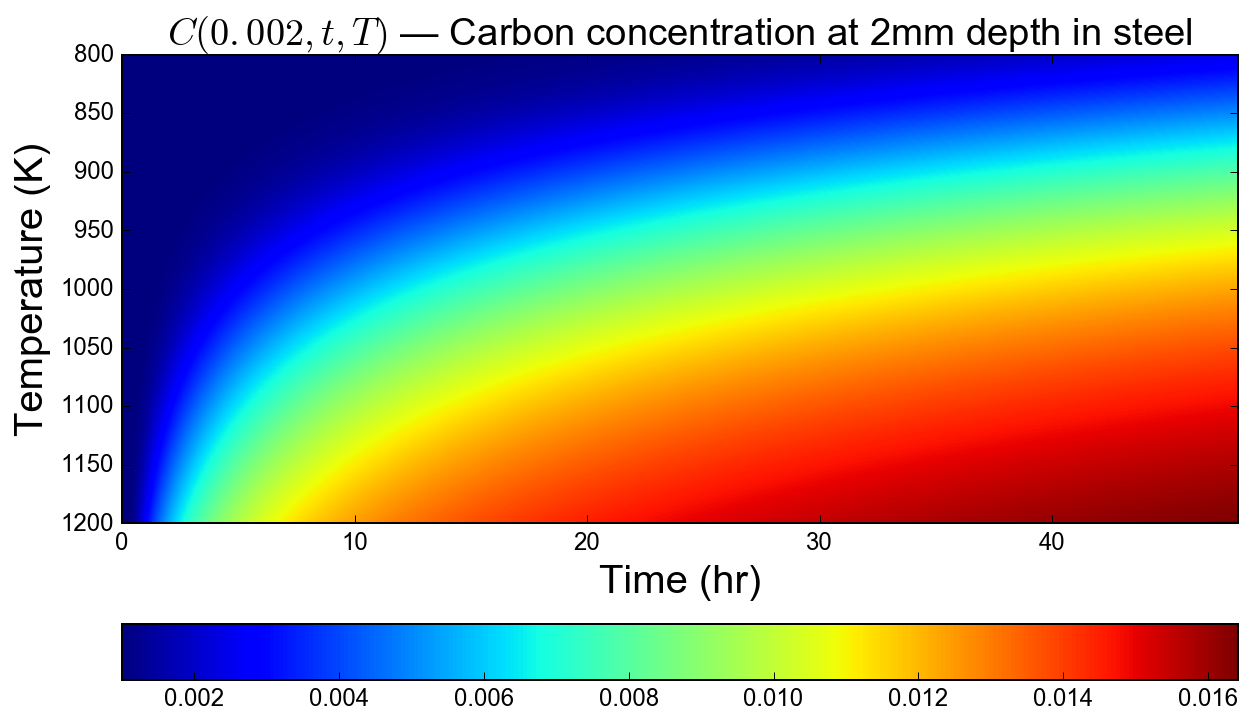

In [15]:
figure()
imshow(v['C2mm'], extent=[0,48, 1200, 800], aspect='auto')
colorbar(orientation='horizontal')
title('$C(0.002,t,T)$ — Carbon concentration at 2mm depth in steel')
xlabel('Time (hr)')
ylabel('Temperature (K)')

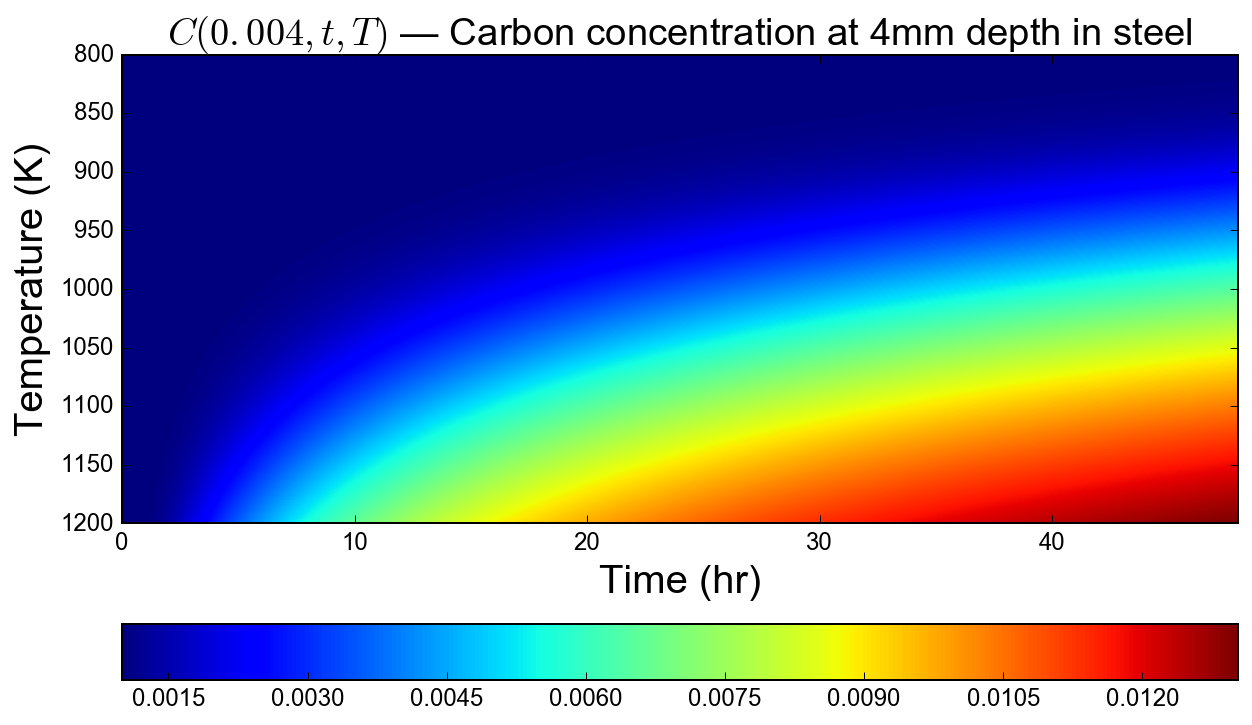

In [16]:
figure()
imshow(v['C4mm'], extent=[0,48, 1200, 800], aspect='auto')
colorbar(orientation='horizontal')
title('$C(0.004,t,T)$ — Carbon concentration at 4mm depth in steel')
xlabel('Time (hr)')
ylabel('Temperature (K)')

These graphs use the `C()` function I implemented in `carbon.cpp` to determine Carbon concentration at a constant depth (2mm and 4mm respectively). The lines parallel to the x-axis represent different carburizing processes, which vary by temperature, and the span of these lines is the procession of time from the start to two days later. It is apparent in both graphs, more prominently in the first one, that higher temperature correlates positively with an increase in concentration by day 2, as well as an increase in the rate of change of concentration. The lesson to carburizing kiln operators is to find an optimization of temperature where carburizing reaches the target concentration fast enough without using too much fuel to maintain higher temperature. However, even the max temperature evaluated, 1200K, is just under 1000°C, a temperature commonly achieved even in common ceramicist's kilns and maintained for long periods of time — and it seems that any increase in fuel expenditure per unit time is overcompensated by foreshortening the time-to-completion in a carburization process with a target at-depth concentration. Another obvious determination from the two graphs is that, at higher depths from the surface of a carburizing steel sample, the increase in carbon concentration is delayed, and thus in the same amount of time, 4mm reaches a lesser concentration than at 2mm. That is to say, there is a negative correlation between depth and concentration at a fixed point in time.

([<matplotlib.axis.XTick at 0x11470d6a0>,
 <a list of 6 Text xticklabel objects>)

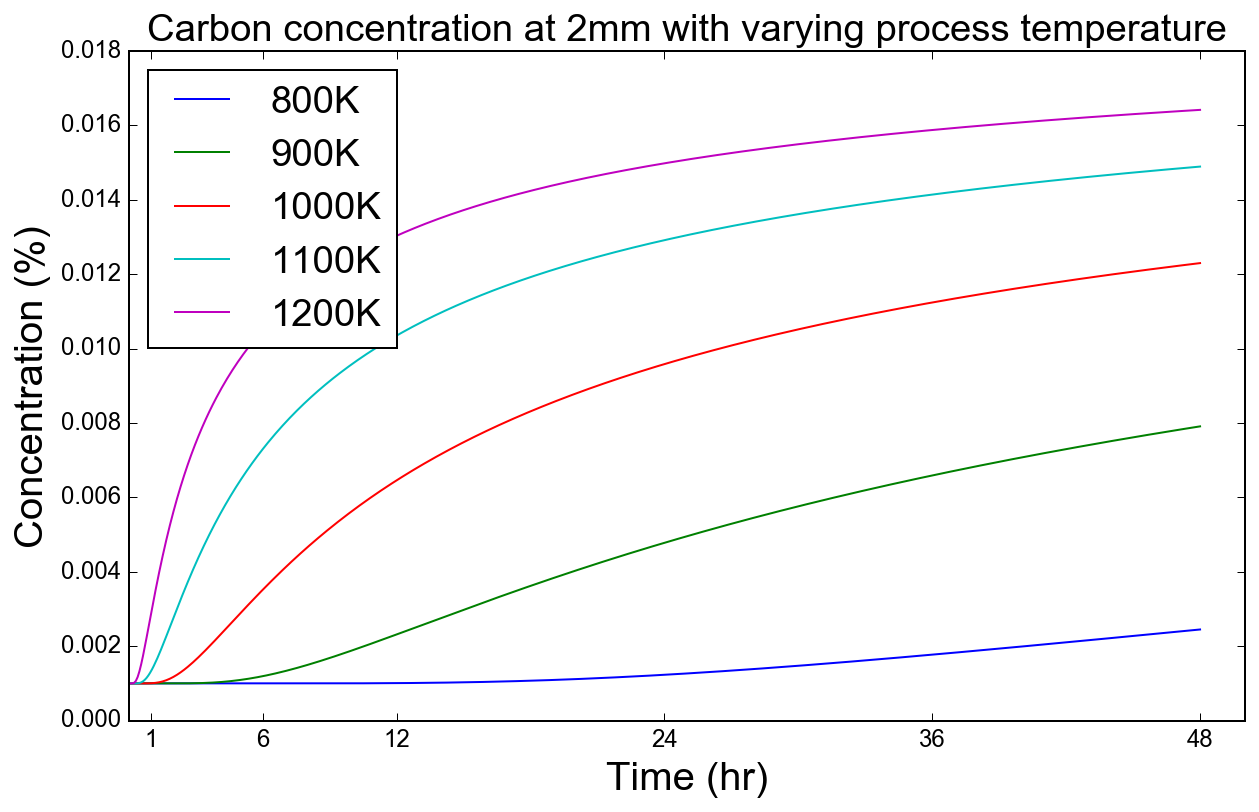

In [17]:
figure()
plot(v['time'], v['C2mm_800K'], 
     v['time'], v['C2mm_900K'], 
     v['time'], v['C2mm_1000K'], 
     v['time'], v['C2mm_1100K'],
     v['time'], v['C2mm_1200K'])
title('Carbon concentration at 2mm with varying process temperature')
xlabel('Time (hr)')
ylabel('Concentration (%)')
legend(['800K','900K','1000K','1100K','1200K'],loc=2)
xticks( (1*3600, 6*3600, 12*3600, 24*3600, 36*3600, 48*3600),
        ('1', '6', '12', '24', '36', '48') )

([<matplotlib.axis.XTick at 0x1137b8550>,
 <a list of 6 Text xticklabel objects>)

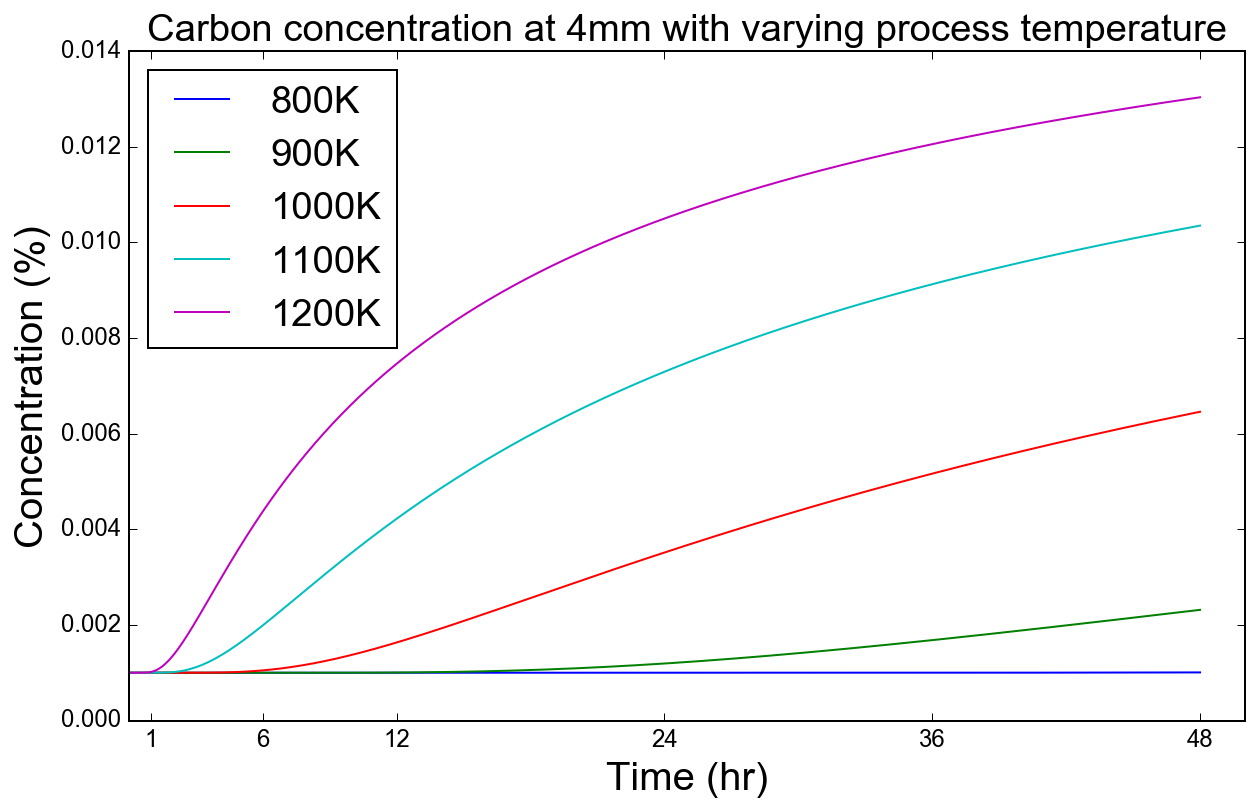

In [18]:
figure()
plot(v['time'], v['C4mm_800K'], 
     v['time'], v['C4mm_900K'], 
     v['time'], v['C4mm_1000K'], 
     v['time'], v['C4mm_1100K'],
     v['time'], v['C4mm_1200K'])
title('Carbon concentration at 4mm with varying process temperature')
xlabel('Time (hr)')
ylabel('Concentration (%)')
legend(['800K','900K','1000K','1100K','1200K'],loc=2)
xticks( (1*3600, 6*3600, 12*3600, 24*3600, 36*3600, 48*3600),
        ('1', '6', '12', '24', '36', '48') )

These graphs reveal that, over time, the concentration at a fixed point increases in an approximately logarithmic fashion at higher temperatures, and a lower temperature carburizing process causes concentration to follow a much shallower, roughly exponential trend. Of course, the function for concentration over time is more complex than this, but it does reveal practical implications in the procession of concentration over time in real-world implementation. Carburizing kiln operators need be aware of a visibly prominent "hump" in higher temperature carburization that is nonexistant in low temperature processes. 900K carburizing will gradually increase in rate of change (henceforth "acceleration"), whereas 1000K carburizing accelerates and then more gradually decelerates. Processes at temperatures greater than 1100K demonstrate very prominent and rapid acceleration in concentration increases throughout the depths of the steel sample, and then rapidly decelerates to a slow, linear pace of concentration change. If the process of carburization involves risks as concentration changes, then it is the responsibility of mill and kiln managers to be very aware of the characteristic slope of the concentration function as it varies over kiln temperature. Of course, these graphs all accomodate only one scenario: that of constant kiln temperature throughout the entire process. Theoretically, in a real-world application, temperature could change deliberately or otherwise for reasons of precision, efficiency, or some combination of the two as the steel approaches a certain concentration at a constant depth. Thus these graphs do not tell the whole story of realistic carburizing processes but do lend some perspective and visualization into how temperature greatly affects the behavior of the process.